# **Seoul-Bike-Sharing-Demand**

The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information.

https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

# Importing libraries and data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [13]:
df = pd.read_csv('./SeoulBikeData.csv')

In [14]:
df = df.drop(columns=['Date', 'Holiday', 'Seasons'])

In [15]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind",
                "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df.columns = dataset_cols

In [16]:
df['functional'] = (df['functional'] == 'YES').astype(int)

In [17]:
df = df[df['hour'] == 12]
df = df.drop(columns=['hour'])

# Analyzing features

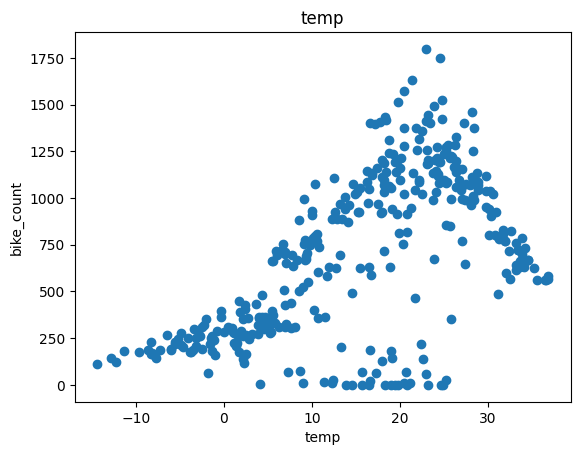

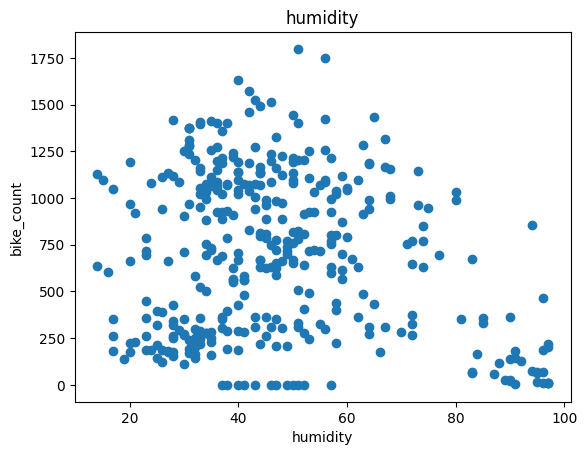

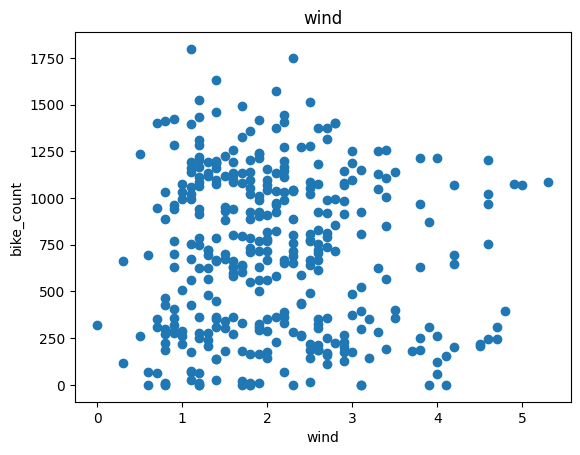

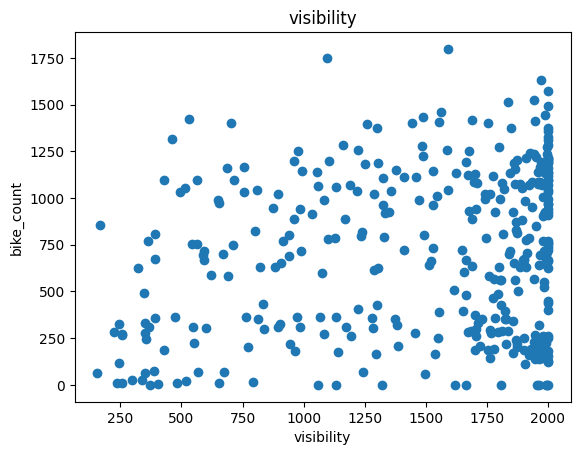

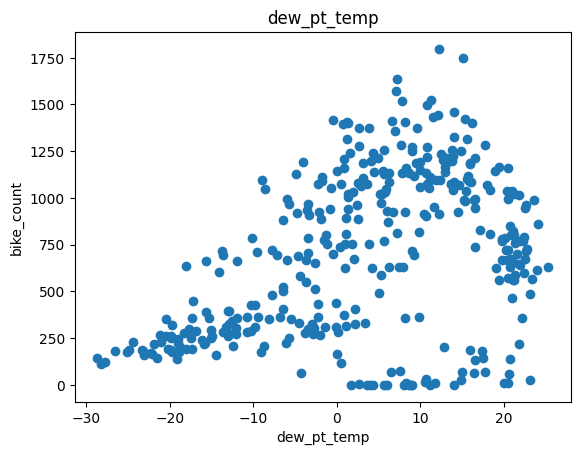

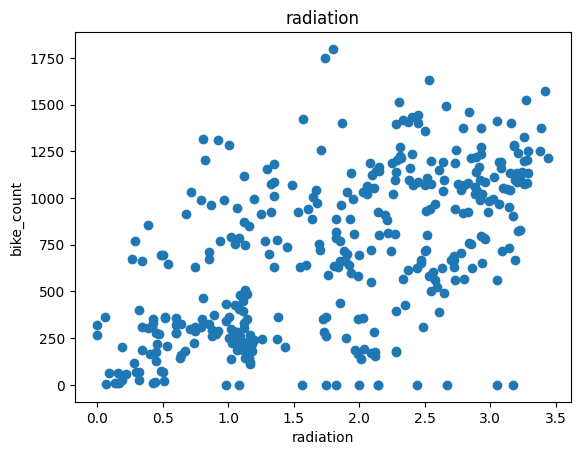

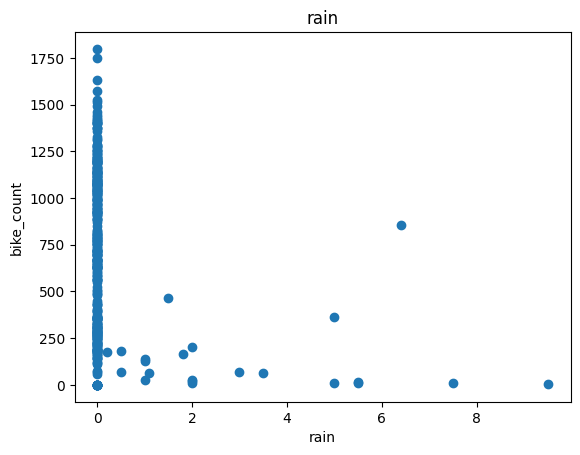

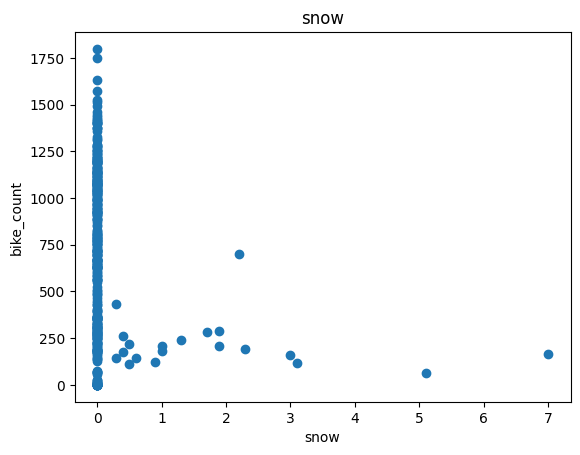

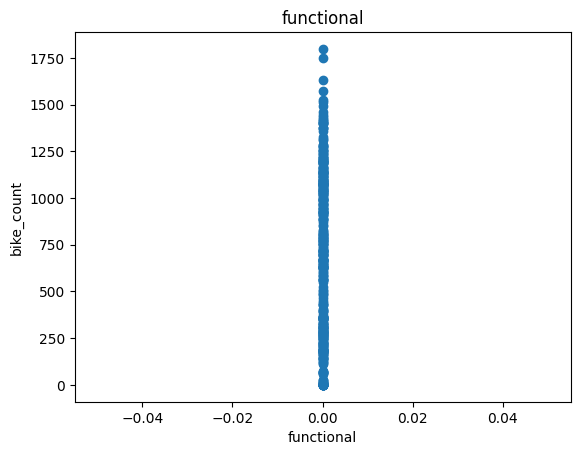

In [18]:
for label in df.columns[1:]:
    _ = plt.scatter(df[label], df['bike_count'])
    _ = plt.title(label)
    _ = plt.ylabel('bike_count')
    _ = plt.xlabel(label)
    _ = plt.show()

In [19]:
df = df.drop(columns=['wind', 'visibility', 'functional'])

# Train/valid/test splitting

In [20]:
# Get feature matrix X with only the selected features

def get_Xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)

    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))

    return data, X, y

In [21]:
train, val, test = np.split(
    df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [22]:
_, X_train_temp, y_train_temp = get_Xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_Xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_Xy(test, "bike_count", x_labels=["temp"])

# LinearRegression()

In [23]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [24]:
temp_reg.coef_
temp_reg.intercept_

array([[20.6180745]])

array([371.94770184])

In [25]:
temp_reg.score(X_test_temp, y_test_temp)

0.2658854741351986

# Plotting: Data vs Fit

In [26]:
def plot_data_fit(model):
    _ = plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")

    X = tf.linspace(-20, 40, 100)
    _ = plt.plot(X, model.predict(np.array(X).reshape(-1, 1)),
                 label="Fit", color="red", linewidth=3)

    _ = plt.legend()
    _ = plt.title("Bikes vs Temp")
    _ = plt.ylabel("Number of bikes")
    _ = plt.xlabel("Temp")
    _ = plt.show()

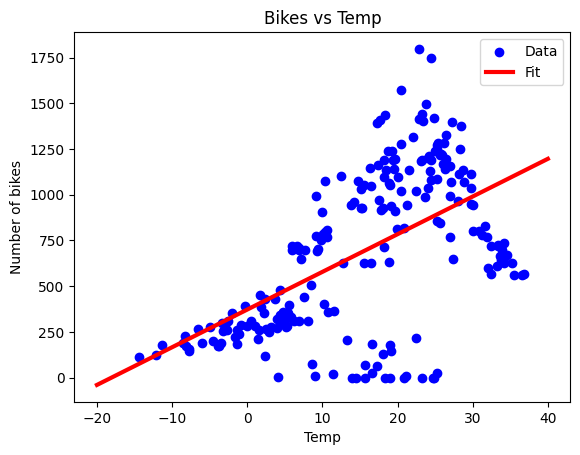

In [27]:
plot_data_fit(temp_reg)

# Multiple linear regression

In [28]:
train, val, test = np.split(
    df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [29]:
_, X_train_all, y_train_all = get_Xy(
    train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_Xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_Xy(test, "bike_count", x_labels=df.columns[1:])

In [30]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [31]:
all_reg.score(X_test_all, y_test_all)

0.48065650629727763

In [32]:
# ValueError: X has 1 features, but LinearRegression is expecting 6 features as input.
# plot_data_fit(all_reg)

# Linear regression using a neuron

In [33]:
def plot_loss(history):
    _ = plt.plot(history.history['loss'], label='loss')
    _ = plt.plot(history.history['val_loss'], label='val_loss')
    _ = plt.xlabel('Epoch')
    _ = plt.ylabel('MSE')
    _ = plt.legend()
    _ = plt.grid(True)
    _ = plt.show()

In [34]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [35]:
temp_neuron_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [36]:
temp_neuron_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.1), loss='mean_squared_error')

In [37]:
history = temp_neuron_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

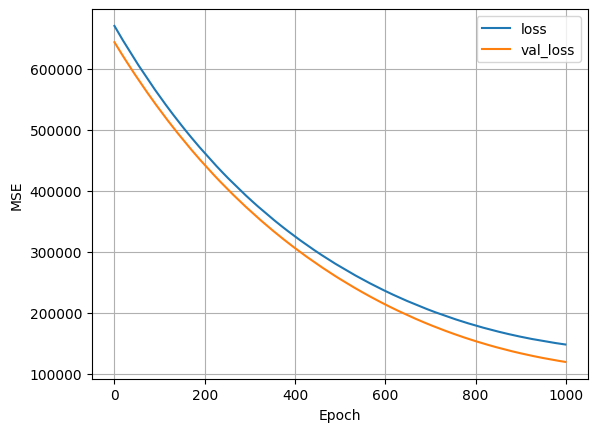

In [38]:
plot_loss(history)

4/4 [==============================] - 0s 1ms/step


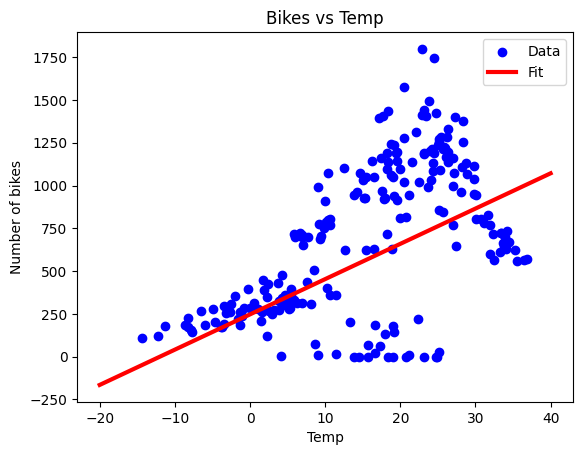

In [39]:
plot_data_fit(temp_neuron_model)

# Regression using neural network

In [40]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [41]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [42]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), loss='mean_squared_error')

In [43]:
history = temp_nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0, epochs=100
)

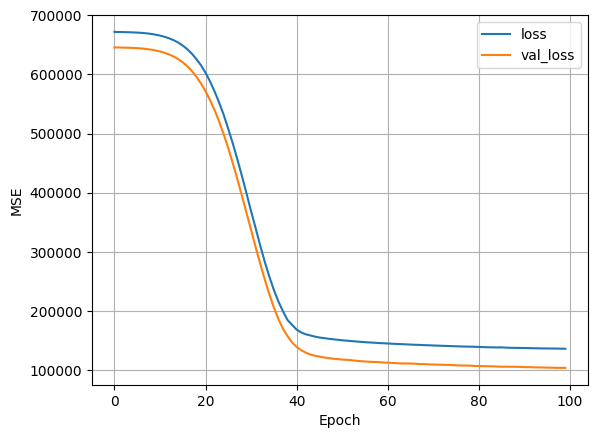

In [44]:
plot_loss(history)

4/4 [==============================] - 0s 2ms/step


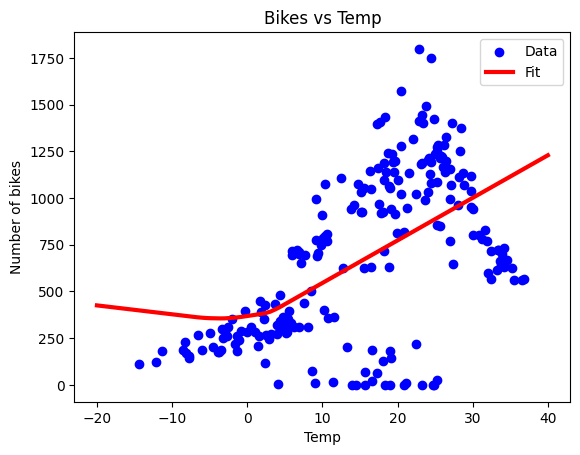

In [45]:
plot_data_fit(temp_nn_model)

# Neural network with all the features

In [46]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

In [47]:
all_nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), loss='mean_squared_error')

In [48]:
history = all_nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
)

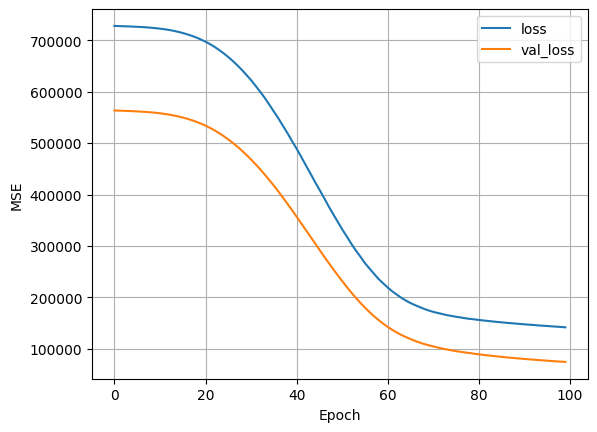

In [49]:
plot_loss(history)

4/4 [==============================] - 0s 1ms/step


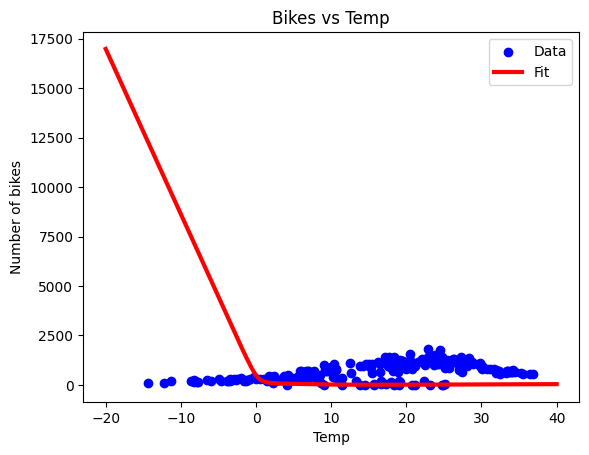

In [50]:
plot_data_fit(all_nn_model)

# Linear Regression vs NN Regression

In [51]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = all_nn_model.predict(X_test_all)

3/3 [==============================] - 0s 1ms/step


In [52]:
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [53]:
MSE(y_pred_lr, y_test_all)
MSE(y_pred_nn, y_test_all)

105133.84638908463

118206.19250609264

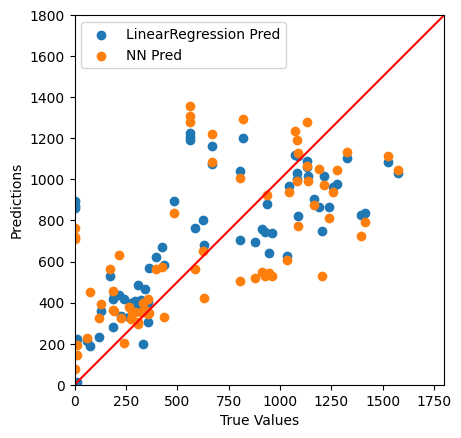

In [54]:
ax = plt.axes(aspect="equal")
_ = plt.scatter(y_test_all, y_pred_lr, label="LinearRegression Pred")
_ = plt.scatter(y_test_all, y_pred_nn, label="NN Pred")
_ = plt.xlabel("True Values")
_ = plt.ylabel("Predictions")
lims = [0, 1800]
_ = plt.xlim(lims)
_ = plt.ylim(lims)
_ = plt.legend()
_ = plt.plot(lims, lims, c="red")